In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean
import math
import cmath
pi=math.pi
import math
pi=math.pi
def speed(x1,y1,x2,y2):
    x1=x1*pi/180
    x2=x2*pi/180
    y1=y1*pi/180
    y2=y2*pi/180
    d=math.sqrt((math.cos(y2)*(x2-x1))**2+(y2-y1)**2)
    return d*14400*6371
def distance(x1,y1,x2,y2):
    x1=x1*pi/180
    x2=x2*pi/180
    y1=y1*pi/180
    y2=y2*pi/180
    d=math.sqrt((math.cos(y2)*(x2-x1))**2+(y2-y1)**2)
    return d*6371*1000
def vector(x1,y1,x2,y2):
    x1=x1*pi/180
    x2=x2*pi/180
    y1=y1*pi/180
    y2=y2*pi/180

    return complex(math.cos(y2)*(x2-x1),y2-y1)*6371*1000

In [119]:
df=pd.read_csv('nyra_tracking_table.csv')

In [120]:
df_start=pd.read_csv('nyra_start_table.csv')

In [121]:
fst=df_start.columns

In [122]:
fst=pd.DataFrame(fst).T


In [123]:
fst.columns=df_start.columns

In [124]:
df_start=pd.concat([fst, df_start], ignore_index=True)

In [125]:
df_start.columns=['track_id','race_date','race_number','program_number','weight_carried','jockey','odds','position_at_finish']

In [126]:
df_all=pd.DataFrame()
df_all2=pd.DataFrame()
dates=pd.unique(df['race_date'])
dates=dates[0:2]
for date in dates:
    
    races=pd.unique(df[(df['race_date']==date)]['race_number'])
    for race in races:
        tracks=pd.unique(df[(df['race_date']==date)&(df['race_number']==race)]['track_id'])

        for track in tracks:

            df1=df[(df['race_date']==date)&(df['race_number']==race)&(df['track_id']==track)]
            df1.set_index('trakus_index',inplace=True)
            df1=df1.sort_index()
            df1_start=df_start[(df_start['race_date']==date)&(df_start['race_number']==race)&(df_start['track_id']==track)]

            list=pd.unique(df1['program_number'])
            df1['speed']=np.nan

            for item in list:
                df2=df1[df1['program_number']==item]
                
                sd=[]
                for i in range(0,len(df2.index)-1):
                    
                    sd.append(speed(df2['longitude'].iloc[i],df2['latitude'].iloc[i],df2['longitude'].iloc[i+1],df2['latitude'].iloc[i+1]))
                df1.loc[(df1['program_number']==item) &(df1.index!=len(sd)+1), 'speed']=sd
            df0=df1
            df0=df0.reset_index()
            df0.rename(columns={'index':'trakus_index'},inplace=True)
            t=[]
            for i in pd.unique(df0['trakus_index']):
                dff=df0[df0['trakus_index']==i]
                for j in range(0,len(dff.index)):
                    tt=[]
                    
                    for k in range(0,len(dff.index)):
                        tt.append(distance(dff['longitude'].iloc[j],dff['latitude'].iloc[j],dff['longitude'].iloc[k],dff['latitude'].iloc[k]))
                    t.append(mean(tt))
            
            df0.reset_index(inplace=True)
            df0.sort_values(by=['trakus_index','index'],inplace=True)
            

            df0.reset_index(inplace=True)
            df0=pd.concat([df0,pd.DataFrame({'avr_distance':t})],axis=1)
            
            df0.drop(columns=['index','level_0'],inplace=True)
            for item in pd.unique(df0['program_number']):
                df3=df0[df0['program_number']==item]
                df3.reset_index(inplace=True)
                for i in range(0,len(pd.unique(df3['trakus_index']))-1):
                    df0.loc[(df0['program_number']==item)&(df0['trakus_index']==i+1), 'disp_vector']=vector(df3['longitude'].iloc[i],df3['latitude'].iloc[i],df3['longitude'].iloc[i+1],df3['latitude'].iloc[i+1])



            for i in pd.unique(df0['trakus_index']):
                df4=df0[df0['trakus_index']==i]
                
                for j in range(0,len(df4.index)):
                    
                    for k in  (k for k in range(0,len(df4.index)) if k !=j) :
                        a=math.cos(cmath.phase(df4['disp_vector'].iloc[j])-cmath.phase(vector(df4['longitude'].iloc[j],df4['latitude'].iloc[j],df4['longitude'].iloc[k],df4['latitude'].iloc[k])))
                        b=abs(vector(df4['longitude'].iloc[j],df4['latitude'].iloc[j],df4['longitude'].iloc[k],df4['latitude'].iloc[k]))
                        
                        df0.loc[(df0['trakus_index']==i)&(df0['program_number']==df4['program_number'].iloc[j]),k]=a/b

            cc=pd.DataFrame()
            dd=pd.DataFrame()
            for j in range(0,len(df0[df0['trakus_index']==1])):
                c=df0[j].copy()
                c[c<0]=0
                cc=pd.concat([cc,c],axis=1)
                d=df0[j].copy()
                d[d>0]=0
                dd=pd.concat([dd,d],axis=1)


            df0['draft_pos']=cc.sum(axis=1)
            df0['draft_neg']=dd.abs().sum(axis=1)

            df1_start['avr_distance']=np.nan
            df1_start['max_speed']=np.nan
            df1_start['avr_dis_maxspeed']=np.nan


            for item in list:
                df1_start.loc[df1_start['program_number']==item, 'avr_distance']=df0[df0['program_number']==item]['avr_distance'].mean()
                df1_start.loc[df1_start['program_number']==item, 'max_speed']=df0[df0['program_number']==item]['speed'].max()
                df1_start.loc[df1_start['program_number']==item, 'avr_dis_maxspeed']=df0[df0['program_number']==item].loc[df0[df0['program_number']==item]['speed']==df0[df0['program_number']==item]['speed'].max(),'avr_distance'].iloc[0]
                df1_start.loc[df1_start['program_number']==item, 'avr_pos_draft']=df0[df0['program_number']==item]['draft_pos'].mean()
                df1_start.loc[df1_start['program_number']==item, 'avr_neg_draft']=df0[df0['program_number']==item]['draft_neg'].mean()
            fd=df1_start.loc[df1_start['max_speed']==df1_start['max_speed'].max(), 'position_at_finish']
            df_all=pd.concat([df_all,df1_start])
            df_all2=pd.concat([df_all2,df0])

In [127]:
dfx=pd.DataFrame()
dfx['position_at_finish']=pd.unique(df_all['position_at_finish'])
for i in pd.unique(df_all['position_at_finish']):
    dfx.loc[dfx['position_at_finish']==i,'avr_pos_draft']=df_all[df_all['position_at_finish']==i]['avr_pos_draft'].mean()
    dfx.loc[dfx['position_at_finish']==i,'avr_neg_draft']=df_all[df_all['position_at_finish']==i]['avr_neg_draft'].mean()

In [128]:
merged_df = pd.merge(df_all2,df_all,on=['race_date','race_number','program_number'])


In [129]:
dfm=merged_df[merged_df['position_at_finish']==1]

In [130]:
dfm.sort_values('trakus_index',inplace=True)

C:\Users\PC\AppData\Local\Temp\ipykernel_11708\3931341879.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm.sort_values('trakus_index',inplace=True)


In [ ]:
for race in pd.unique(dfm['race_number']):
    tm=max(dfm[dfm['race_number']==race]['trakus_index'])
    dfm.loc[dfm['race_number']==race,'percentage_of_race']=dfm.loc[dfm['race_number']==race,'trakus_index']*100/tm

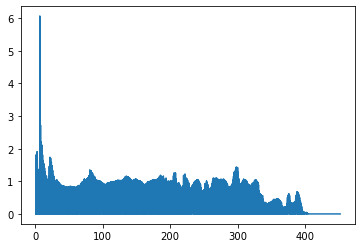

In [131]:
plt.plot(dfm['trakus_index'],dfm['draft_pos'])

(0.0, 90.0)

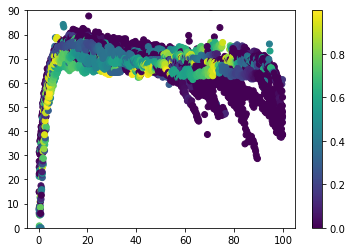

In [149]:
plt.scatter(dfm[dfm['draft_pos']<1]['percentage_of_race'] ,dfm[dfm['draft_pos']<1]['speed'], c=dfm[dfm['draft_pos']<1]['draft_pos'])
plt.colorbar()
plt.ylim(0,90)

(0.0, 90.0)

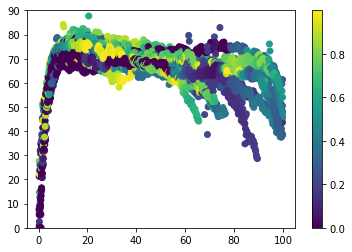

In [135]:
plt.scatter(dfm[dfm['draft_neg']<1]['percentage_of_race'] ,dfm[dfm['draft_neg']<1]['speed'], c=dfm[dfm['draft_neg']<1]['draft_neg'])
plt.colorbar()
plt.ylim(0,90)

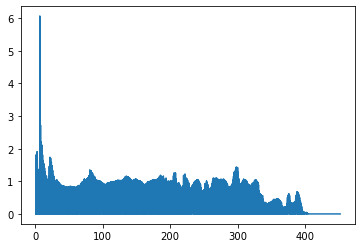

In [136]:
plt.plot(dfm['trakus_index'],dfm['draft_pos'])

<BarContainer object of 12 artists>

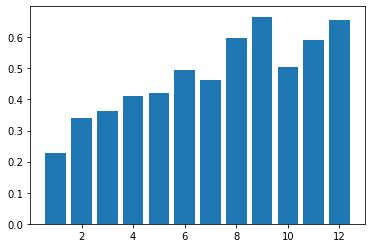

In [177]:
plt.bar( dfx['position_at_finish'],dfx['avr_pos_draft'])


(60.0, 90.0)

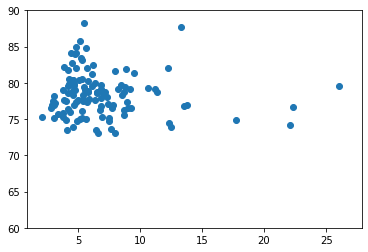

In [138]:
plt.scatter( df_all['avr_dis_maxspeed'],df_all['max_speed'])
plt.ylim(60,90)

(60.0, 90.0)

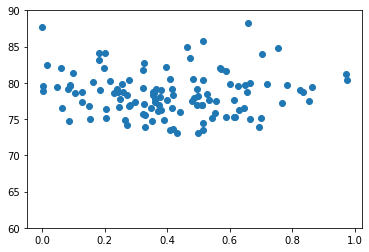

In [139]:
plt.scatter( df_all['avr_pos_draft'],df_all['max_speed'])
plt.ylim(60,90)

(0.0, 90.0)

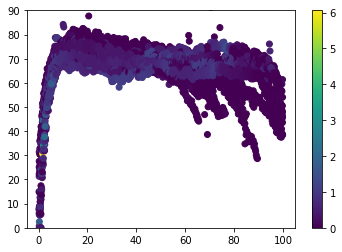

In [141]:
plt.scatter(dfm['percentage_of_race'],dfm['speed'],c=dfm['draft_pos'])
plt.colorbar()
plt.ylim(0,90)

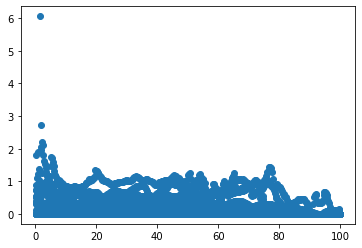

In [175]:
plt.scatter(dfm['percentage_of_race'],dfm['draft_pos'])

(0.0, 90.0)

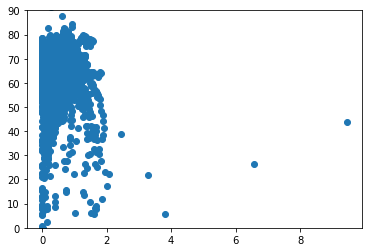

In [172]:
plt.scatter(dfm['draft_neg'],dfm['speed'])
plt.ylim(0,90)

In [159]:
drf=df_all2[(df_all2['race_date']=='2019-04-19')&(df_all2['race_number']==6)]

In [180]:
df_all[(df_all['race_date']=='2019-04-19')&(df_all['race_number']==6)]

,track_id,race_date,race_number,program_number,weight_carried,jockey,odds,position_at_finish,avr_distance,max_speed,avr_dis_maxspeed,avr_pos_draft,avr_neg_draft
3393,AQU,2019-04-19,6,1,119,Junior Alvarado,830,6,22.597885,76.704813,22.337119,0.244560,0.064912
3394,AQU,2019-04-19,6,2,119,Dylan Davis,60,1,19.146541,87.660352,13.277834,0.000184,0.563706
3395,AQU,2019-04-19,6,3,112,Benjamin Hernandez,3800,3,15.142593,76.905193,13.812856,0.375438,0.236213
3396,AQU,2019-04-19,6,4,121,Irad Ortiz Jr.,240,4,14.853358,79.210319,9.222398,0.415379,0.379587
3397,AQU,2019-04-19,6,5,119,Eric Cancel,4150,7,41.871478,74.838366,17.745902,0.266558,0.018355
3398,AQU,2019-04-19,6,6,119,Harry Hernandez,2750,2,15.202022,79.231665,10.637311,0.321584,0.497068
3399,AQU,2019-04-19,6,7,119,Kendrick Carmouche,1080,5,14.793800,79.176488,11.178691,0.363924,0.236402


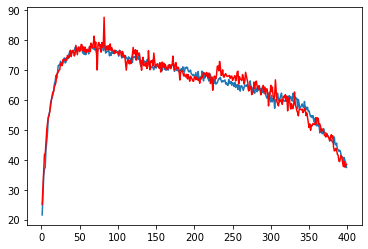

In [179]:
plt.plot(drf[drf['program_number']=='7  ']['trakus_index'],drf[drf['program_number']=='7  ']['speed'])
plt.plot(drf[drf['program_number']=='2  ']['trakus_index'],drf[drf['program_number']=='2  ']['speed'],color='red')